In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.sans-serif"] = "SimHei"

In [3]:
x = np.arange(0, 5, 0.1)
f = lambda x: 2 * np.sin(x) + x ** 0.8
y = f(x)
x_train = np.random.rand(50) * 5
x_train.sort()
y_train = f(x_train) + np.random.normal(0, 0.5, size=50)

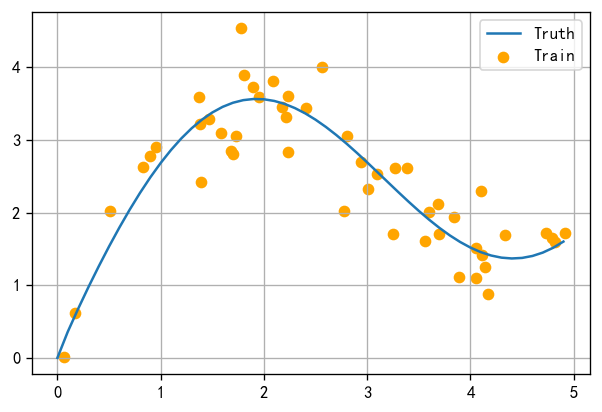

In [4]:
plt.figure(dpi=120)
plt.plot(x, y, label="Truth")
plt.scatter(x_train, y_train, c="orange", marker="o", label="Train")
plt.grid()
plt.legend()
plt.show()

In [5]:
x_tile = np.tile(x_train, (50, 1))
y_tile = np.tile(y_train, (50, 1))
keys = torch.from_numpy(x_tile[(1-np.eye(50)).astype(bool)].reshape(50, -1))
values = torch.from_numpy(y_tile[(1-np.eye(50)).astype(bool)].reshape(50, -1))
quires = torch.from_numpy(x_train.repeat(keys.shape[1]).reshape(50, -1))

In [6]:
class NWKernel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.w = nn.Parameter(torch.rand(1, requires_grad=True))

    def forward(self, quires, keys, values):
        attention_weight = F.softmax(-0.5 * (self.w * (quires - keys))**2, dim=1)
        outcome = torch.bmm(attention_weight.unsqueeze(1), values.unsqueeze(-1))
        return outcome.flatten()

In [7]:
net = NWKernel()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
iters = 800
epoch_loss = list()
for epoch in range(iters):
    optimizer.zero_grad()
    l = loss(net(quires, keys, values), torch.from_numpy(y_train))
    epoch_loss.append(l.detach().numpy())
    l.backward()
    optimizer.step()

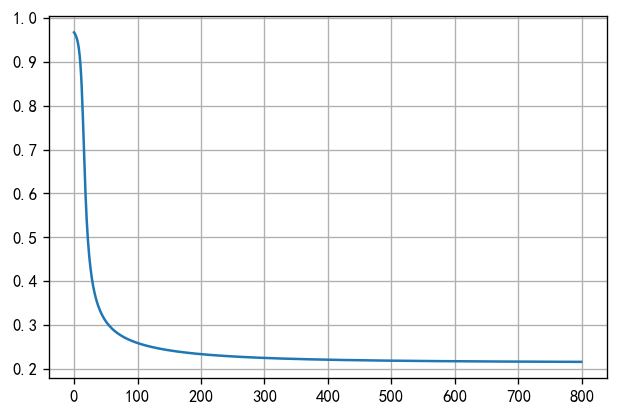

In [8]:
plt.figure(dpi=120)
plt.plot(range(iters), epoch_loss)
plt.grid()
plt.show()

In [9]:
keys = np.tile(x_train, (50, 1))
values = np.tile(y_train, (50, 1))
quires = x.repeat(keys.shape[1]).reshape(50, -1)
y_hat = net(torch.from_numpy(quires), torch.from_numpy(keys), torch.from_numpy(values))

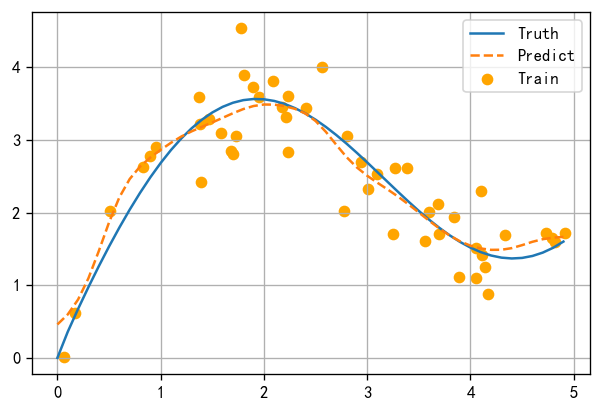

In [10]:
plt.figure(dpi=120)
plt.plot(x, y, label="Truth")
plt.plot(x, y_hat.detach().numpy(), label="Predict", ls="--")
plt.scatter(x_train, y_train, c="orange", marker="o", label="Train")
plt.grid()
plt.legend()
plt.show()

## Additive Attention

In [11]:
class AdditiveAttention(nn.Module):
    def __init__(self, quire_size, key_size, hidden_size, percentage) -> None:
        super().__init__()
        self.W_quire = nn.Linear(quire_size, hidden_size, bias=False)
        self.W_key = nn.Linear(key_size, hidden_size, bias=False)
        self.W_hidden = nn.Linear(hidden_size, 1, bias=False)
        self.dropout = nn.Dropout(percentage)

    def forward(self, quire, key, value, val_len=None):
        self.quire = self.W_quire(quire)
        self.key = self.W_key(key)
        self.score = self.W_hidden(torch.tanh(self.quire.unsqueeze(2) + self.key.unsqueeze(1)))
        self.attention_weight = self.mask_softmax(self.score.squeeze(-1), val_len)
        return torch.bmm(self.dropout(self.attention_weight), value)

    def mask_softmax(self, x, val_len):
        if val_len == None:
            return F.softmax(x, dim=-1)
        if val_len.dim() == 1:
            val = torch.repeat_interleave(val_len, x.shape[1])
        if val_len.dim() > 1:
            val = val_len.flatten()
        shape = x.shape
        x = x.reshape(-1, shape[-1])
        maxlen = torch.arange(x.size(1), dtype=torch.float32)
        mask = maxlen[None, :] >= val[:, None]
        x[mask] = -1e6
        return F.softmax(x.reshape(shape), dim=-1)

In [12]:
quire = torch.normal(0, 1, size=(2, 1, 20))
key = torch.ones(size=(2, 10, 2))
value = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat((2, 1, 1))
net = AdditiveAttention(20, 2, 8, 0.1)
net.eval()
net(quire, key, value, torch.tensor([2, 6]))

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)